In [42]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# ==== Paths (edit DATA_DIR if needed) ====
# If using Colab + Drive, set DATA_DIR to your Drive dataset root.
# Example: DATA_DIR = Path('/content/drive/MyDrive/GTSRB')
DATA_DIR    = Path('../data')   # expects data/Train, data/Test, data/Meta (CSV inside)
MODELS_DIR  = Path('../models')
OUTPUTS_DIR = Path('../outputs')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

TensorFlow: 2.20.0
GPU Available: False


In [43]:
# ============================================================================
# STEP 1: DATA LOADING (Train + Test + Meta)
# ============================================================================

def load_gtsrb_train(data_dir):
    """Load TRAIN split from data_dir/Train/<class>/*."""
    data_dir = Path(data_dir)
    train_path = data_dir / "Train"
    if not train_path.exists():
        raise FileNotFoundError(f"Missing: {train_path}")
    images, labels = [], []
    classes = sorted([d for d in os.listdir(train_path) if (train_path / d).is_dir()])
    print(f"Found {len(classes)} Train classes")
    for class_num in classes:
        class_path = train_path / class_num
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png','.jpg','.jpeg','.ppm')):
                img = cv2.imread(str(class_path / f))
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img); labels.append(int(class_num))
        if int(class_num) % 10 == 0:
            print(f"  Loaded class {class_num}...")
    return images, np.array(labels)

def _find_test_labels_csv(test_dir: Path, data_dir: Path):
    """Find a CSV containing ClassId + (Path|Filename)."""
    candidates = list(test_dir.glob("*.csv")) + list(data_dir.glob("*.csv"))
    if (data_dir/'Meta').exists():
        candidates += list((data_dir/'Meta').glob("*.csv"))
    for csv_path in candidates:
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            continue
        cols_lower = {c.lower(): c for c in df.columns}
        if 'classid' in cols_lower and any(k in cols_lower for k in ['path','filename']):
            return csv_path
        if 'classid' in cols_lower and any('file' in c.lower() for c in df.columns):
            return csv_path
    return None

def load_gtsrb_test_with_csv(data_dir):
    """
    Load OFFICIAL TEST split from data_dir/Test/* using a labels CSV.
    Supports common variants (Test.csv, GT-final_test.csv, etc.).
    """
    data_dir = Path(data_dir)
    test_dir = data_dir / "Test"
    if not test_dir.exists():
        raise FileNotFoundError(f"Missing: {test_dir}")

    csv_path = _find_test_labels_csv(test_dir, data_dir)
    if csv_path is None:
        raise FileNotFoundError("Could not find a labels CSV for Test/ (e.g., Test.csv or GT-final_test.csv).")

    df = pd.read_csv(csv_path)
    cols = {c.lower(): c for c in df.columns}
    # filename column
    if 'path' in cols: file_col = cols['path']
    elif 'filename' in cols: file_col = cols['filename']
    else:
        file_col = next((c for c in df.columns if 'file' in c.lower()), None)
        if file_col is None:
            raise ValueError(f"Can't infer filename column in {csv_path.name}")
    # class column
    class_col = cols.get('classid', None)
    if class_col is None:
        raise ValueError(f"No 'ClassId' column in {csv_path.name}")

    images_test, labels_test = [], []
    for _, row in df.iterrows():
        rel = str(row[file_col])
        img_path = (data_dir / rel) if rel.startswith("Test") else (test_dir / rel)
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images_test.append(img); labels_test.append(int(row[class_col]))

    if not images_test:
        raise RuntimeError("Loaded 0 test images. Check CSV filenames vs files in Test/.")
    return images_test, np.array(labels_test)

def load_gtsrb_meta_classnames(data_dir):
    """
    Read class names from Meta/*.csv (e.g., signnames.csv or similar).
    Returns {class_id: sign_name}. If not found, returns {}.
    """
    data_dir = Path(data_dir)
    candidates = []
    if (data_dir/'Meta').exists():
        candidates += list((data_dir/'Meta').glob("*.csv"))
    candidates += list(data_dir.glob("*.csv"))
    for csv_path in candidates:
        try:
            df = pd.read_csv(csv_path)
            cols = {c.lower(): c for c in df.columns}
            if 'classid' in cols and ('signname' in cols or 'classname' in cols or 'name' in cols):
                name_col = cols.get('signname') or cols.get('classname') or cols.get('name')
                mapping = {int(row[cols['classid']]): str(row[name_col]) for _, row in df.iterrows()}
                print(f"✓ Loaded class names from {csv_path.name}")
                return mapping
        except Exception:
            continue
    print("⚠️ No Meta file found — using numeric class IDs only.")
    return {}

def load_gtsrb_train_plus_test(data_dir):
    """Load Train/ and Test/ (with CSV) and concatenate."""
    imgs_tr, y_tr = load_gtsrb_train(data_dir)
    try:
        imgs_te, y_te = load_gtsrb_test_with_csv(data_dir)
    except Exception as e:
        print(f"[Info] Could not load Test/ with labels ({e}). Using Train/ only.")
        imgs_te, y_te = [], np.array([])
    images = imgs_tr + imgs_te
    labels = np.concatenate([y_tr, y_te]) if len(y_te) else y_tr
    print(f"\n✓ Combined dataset: {len(images)} images  ({len(y_tr)} train + {len(y_te)} test)")
    return images, labels

In [44]:
# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================

def preprocess_data(images, labels, img_size=32):
    """
    Resize -> normalize [0,1] -> flatten -> one-hot labels.
    """
    print("\n" + "="*70)
    print("PREPROCESSING DATA")
    print("="*70)
    resized_images = np.array([cv2.resize(img, (img_size, img_size)) for img in images])
    normalized_images = resized_images.astype('float32') / 255.0
    flattened_images = normalized_images.reshape(len(normalized_images), -1)
    n_classes = len(np.unique(labels))
    labels_categorical = to_categorical(labels, n_classes)
    print(f"✓ Preprocessed: {flattened_images.shape} (features), labels: {labels_categorical.shape}")
    return flattened_images, labels_categorical, n_classes, normalized_images

In [45]:
# ============================================================================
# STEP 2.5: LIGHT DATA AUGMENTATION
# ============================================================================

def _rand_brightness_contrast(img, b_range=(0.85, 1.15), c_range=(0.85, 1.15)):
    b = np.random.uniform(*b_range); c = np.random.uniform(*c_range)
    return np.clip(img * c * b, 0, 255).astype(np.uint8)

def _rand_rotate(img, max_deg=8):
    h, w = img.shape[:2]; ang = np.random.uniform(-max_deg, max_deg)
    M = cv2.getRotationMatrix2D((w/2, h/2), ang, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

def _rand_blur(img, p=0.3):
    return cv2.GaussianBlur(img, (3,3), 0) if np.random.rand() < p else img

def augment_images(images, times=1):
    """
    Return list with originals + augmented copies.
    times=1 doubles the data (1 augmented copy per original).
    """
    aug = []
    for img in images:
        aug.append(img)
        for _ in range(times):
            x = _rand_brightness_contrast(img)
            x = _rand_blur(x)
            x = _rand_rotate(x, max_deg=8)
            aug.append(x)
    return aug

In [46]:
# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================================================

def visualize_samples(images, labels, n_samples=20):
    print("\nVisualizing sample images...")
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Sample Traffic Signs from Dataset', fontsize=16, fontweight='bold')
    indices = np.random.choice(len(images), n_samples, replace=False)
    for i, ax in enumerate(axes.flat):
        idx = indices[i]
        ax.imshow(images[idx])
        label = np.argmax(labels[idx]) if len(getattr(labels[idx], "shape", ())) > 0 else labels[idx]
        ax.set_title(f'Class: {label}', fontsize=11)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'samples.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_class_distribution(labels):
    print("\nPlotting class distribution...")
    if len(getattr(labels, "shape", ())) > 1:
        class_counts = np.argmax(labels, axis=1)
    else:
        class_counts = labels
    plt.figure(figsize=(16, 5))
    unique, counts = np.unique(class_counts, return_counts=True)
    plt.bar(unique, counts, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Class'); plt.ylabel('Count')
    plt.title('Distribution of Traffic Sign Classes')
    plt.xticks(unique); plt.grid(axis='y', alpha=0.3)
    for i, (cls, cnt) in enumerate(zip(unique, counts)):
        if i % 3 == 0:
            plt.text(cls, cnt + max(5, int(0.01 * counts.max())), str(cnt), ha='center', fontsize=8)
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

In [47]:
# ============================================================================
# STEP 4: BUILD MLP MODEL (with mild L2 regularization)
# ============================================================================

def build_mlp_model(input_shape, n_classes):
    print("\n" + "="*70)
    print("BUILDING MLP MODEL (L2 regularization)")
    print("="*70)

    l2w = 1e-4  # mild weight decay

    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,), name='hidden_layer_1',
              kernel_regularizer=l2(l2w)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu', name='hidden_layer_2',
              kernel_regularizer=l2(l2w)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu', name='hidden_layer_3',
              kernel_regularizer=l2(l2w)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(n_classes, activation='softmax', name='output_layer')
    ], name='Traffic_Sign_MLP')

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("\n✓ Model built successfully (with L2)")
    return model

In [48]:
# ============================================================================
# STEP 5: TRAIN MODEL
# ============================================================================

def train_model(model, X_train, y_train, X_val=None, y_val=None,
                epochs=50, batch_size=128, validation_split=None):
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)

    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    checkpoint = ModelCheckpoint(
        filepath=str(MODELS_DIR / 'best_traffic_sign_mlp.h5'),
        monitor='val_accuracy', save_best_only=True, verbose=1
    )

    if validation_split is not None:
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=validation_split,   # e.g., 0.05
            callbacks=[early_stop, reduce_lr, checkpoint],
            shuffle=True,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[early_stop, reduce_lr, checkpoint],
            shuffle=True,
            verbose=1
        )
    return history

def plot_training_history(history):
    print("\nPlotting training history...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ax1.plot(history.history['accuracy'], label='Training', linewidth=2.0)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2.0)
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy'); ax1.set_title('Accuracy'); ax1.legend(); ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['loss'], label='Training', linewidth=2.0)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2.0)
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.set_title('Loss'); ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

In [49]:
# ============================================================================
# STEP 6: EVALUATE MODEL
# ============================================================================

def evaluate_model(model, X_test, y_test):
    print("\n" + "="*70)
    print("EVALUATING MODEL")
    print("="*70)
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{'='*70}")
    print(f"  HOLD-OUT ACCURACY: {accuracy*100:.2f}%")
    print(f"{'='*70}\n")

    report = classification_report(y_true, y_pred, zero_division=0)
    print("Classification Report:\n", report)

    with open(OUTPUTS_DIR / 'classification_report.txt', 'w') as f:
        f.write(f"Hold-out Accuracy: {accuracy*100:.2f}%\n\n")
        f.write(report)
    return y_pred, y_true, y_pred_probs

def plot_confusion_matrix(y_true, y_pred, n_classes, class_names=None):
    print("\nPlotting confusion matrix...")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, square=True)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title('Confusion Matrix - Traffic Sign Classification')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, X_test, y_test, images_test, n_samples=10, class_names=None):
    print("\nVisualizing sample predictions...")
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    fig, axes = plt.subplots(2, 5, figsize=(18, 7))
    fig.suptitle('Model Predictions on Hold-out Images', fontsize=16, fontweight='bold')
    for i, ax in enumerate(axes.flat):
        idx = indices[i]
        pred = model.predict(X_test[idx:idx+1], verbose=0)
        pred_class = int(np.argmax(pred))
        true_class = int(np.argmax(y_test[idx]))
        confidence = float(np.max(pred)) * 100
        ax.imshow(images_test[idx])
        def name(c): 
            return class_names.get(c, f'Class {c}') if class_names else f'Class {c}'
        color = 'green' if pred_class == true_class else 'red'
        status = '✓ CORRECT' if pred_class == true_class else '✗ WRONG'
        ax.set_title(f'{status}\nTrue: {name(true_class)} | Pred: {name(pred_class)}\nConf: {confidence:.1f}%',
                     color=color, fontsize=10, fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [50]:
# ============================================================================
# STEP 7: ROBUST SINGLE-IMAGE PREDICTION
# ============================================================================

def _letterbox_rgb(img_rgb, target=32):
    h, w = img_rgb.shape[:2]
    if h == w:
        square = img_rgb
    elif h > w:
        pad = (h - w) // 2
        square = cv2.copyMakeBorder(img_rgb, 0, 0, pad, h - w - pad, cv2.BORDER_CONSTANT, value=(0,0,0))
    else:
        pad = (w - h) // 2
        square = cv2.copyMakeBorder(img_rgb, pad, w - h - pad, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    return cv2.resize(square, (target, target), interpolation=cv2.INTER_AREA)

def _enhance_contrast(img_rgb):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    L = clahe.apply(L)
    lab = cv2.merge([L, A, B])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def _preprocess_for_mlp(img_bgr, img_size=32):
    if img_bgr is None: return None, None
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = _enhance_contrast(img_rgb)
    img_rgb = cv2.medianBlur(img_rgb, 3)
    img_rgb = _letterbox_rgb(img_rgb, target=img_size)
    arr = img_rgb.astype('float32')/255.0
    flat = arr.reshape(1, -1)
    return img_rgb, flat

def predict_traffic_sign_robust(model, image_path, img_size=32, class_names=None,
                                tta=True, unknown_threshold=0.55, return_probs=False):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    disp_img, x = _preprocess_for_mlp(img_bgr, img_size=img_size)
    if x is None:
        raise ValueError("Preprocess failed.")

    if not tta:
        probs = model.predict(x, verbose=0)[0]
    else:
        angles = [-10, 0, 10]
        acc = []
        h, w = img_bgr.shape[:2]
        for a in angles:
            M = cv2.getRotationMatrix2D((w/2, h/2), a, 1.0)
            rot = cv2.warpAffine(img_bgr, M, (w, h), borderValue=(0,0,0))
            _, x_rot = _preprocess_for_mlp(rot, img_size=img_size)
            acc.append(model.predict(x_rot, verbose=0)[0])
        probs = np.mean(acc, axis=0)

    top_idx = int(np.argmax(probs))
    top_conf = float(np.max(probs))
    label = class_names.get(top_idx, f"Class {top_idx}") if class_names else f"Class {top_idx}"

    unknown = top_conf < unknown_threshold
    title = f"{'Unknown' if unknown else label}  ({top_conf*100:.1f}%)"

    plt.figure(figsize=(6,5))
    plt.imshow(disp_img); plt.title(title, color=('red' if unknown else 'green'), fontsize=12, fontweight='bold')
    plt.axis('off'); plt.tight_layout(); plt.show()

    top3 = np.argsort(probs)[-3:][::-1]
    print("Top-3:")
    for i, idx in enumerate(top3, 1):
        name = class_names.get(idx, f'Class {idx}') if class_names else f'Class {idx}'
        print(f"  {i}. {name}: {probs[idx]*100:.2f}%")

    result = {"pred_index": (None if unknown else top_idx),
              "pred_label": ("Unknown" if unknown else label),
              "confidence": top_conf,
              "unknown": unknown}
    if return_probs:
        result["probs"] = probs
    return result

In [51]:
# ============================================================================
# MAIN PIPELINE — Train on Train+Test, 5% hold-out for evaluation
# ============================================================================

def main():
    print("\n" + "="*70)
    print("  TRAFFIC SIGN RECOGNITION USING MLP — Train on Train+Test (5% hold-out)")
    print("="*70)

    # 0) Class names (for nicer labels)
    class_names = load_gtsrb_meta_classnames(DATA_DIR)

    # 1) Load Train + Test (with labels)
    images_all, labels_all = load_gtsrb_train_plus_test(DATA_DIR)

    # 2) Reserve 5% as validation (stratified)
    X_imgs_tr, X_imgs_val, y_tr_raw, y_val_raw = train_test_split(
        images_all, labels_all, test_size=0.05, random_state=42, stratify=labels_all
    )
    print(f"\nCombined: {len(images_all)} images → Train: {len(X_imgs_tr)} | Val: {len(X_imgs_val)}")

    # 3) Augment training images lightly for robustness (set to 0 to disable)
    AUG_TIMES = 1  # 0 for speed, 1 for robustness
    if AUG_TIMES > 0:
        print(f"Augmenting training images (times={AUG_TIMES})...")
        X_imgs_tr = augment_images(X_imgs_tr, times=AUG_TIMES)
        y_tr_raw  = np.repeat(y_tr_raw, repeats=(1 + AUG_TIMES))

    # 4) Preprocess both splits
    X_train, y_train, n_classes, _ = preprocess_data(X_imgs_tr, y_tr_raw, img_size=32)
    X_val,   y_val,   _,         val_norm = preprocess_data(X_imgs_val, y_val_raw, img_size=32)

    # 5) EDA (optional)
    visualize_samples(val_norm[:min(1000, len(val_norm))], to_categorical(y_val_raw, n_classes)[:min(1000, len(y_val_raw))], n_samples=20)
    plot_class_distribution(to_categorical(labels_all, n_classes))

    # 6) Build & Train (explicit validation set)
    model = build_mlp_model(input_shape=X_train.shape[1], n_classes=n_classes)
    model.summary()
    history = train_model(model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=50, batch_size=128)
    plot_training_history(history)

    # 7) Evaluate on the 5% hold-out validation set
    y_pred, y_true, y_pred_probs = evaluate_model(model, X_val, y_val)
    plot_confusion_matrix(y_true, y_pred, n_classes, class_names=class_names)
    visualize_predictions(model, X_val, y_val, val_norm, n_samples=10, class_names=class_names)

    # 8) Save final model + info
    final_model_path = MODELS_DIR / 'traffic_sign_mlp_final.h5'
    model.save(final_model_path)
    print(f"\n✓ Model saved as '{final_model_path}'")

    info_path = MODELS_DIR / 'model_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump({'n_classes': n_classes, 'img_size': 32}, f)
    print(f"✓ Model info saved as '{info_path}'")

    print("\n" + "="*70)
    print("  TRAINING COMPLETE (Train+Test with 5% hold-out)!")
    print("="*70)

    # Return for summary cell below
    return model, y_pred, y_true, y_pred_probs, X_val, y_val, class_names


  TRAFFIC SIGN RECOGNITION USING MLP — Train on Train+Test (5% hold-out)
⚠️ No Meta file found — using numeric class IDs only.
Found 43 Train classes
  Loaded class 0...
  Loaded class 10...
  Loaded class 20...
  Loaded class 30...
  Loaded class 40...

✓ Combined dataset: 51839 images  (39209 train + 12630 test)

Combined: 51839 images → Train: 49247 | Val: 2592
Augmenting training images (times=1)...

PREPROCESSING DATA
✓ Preprocessed: (98494, 3072) (features), labels: (98494, 43)

PREPROCESSING DATA
✓ Preprocessed: (2592, 3072) (features), labels: (2592, 43)

Visualizing sample images...


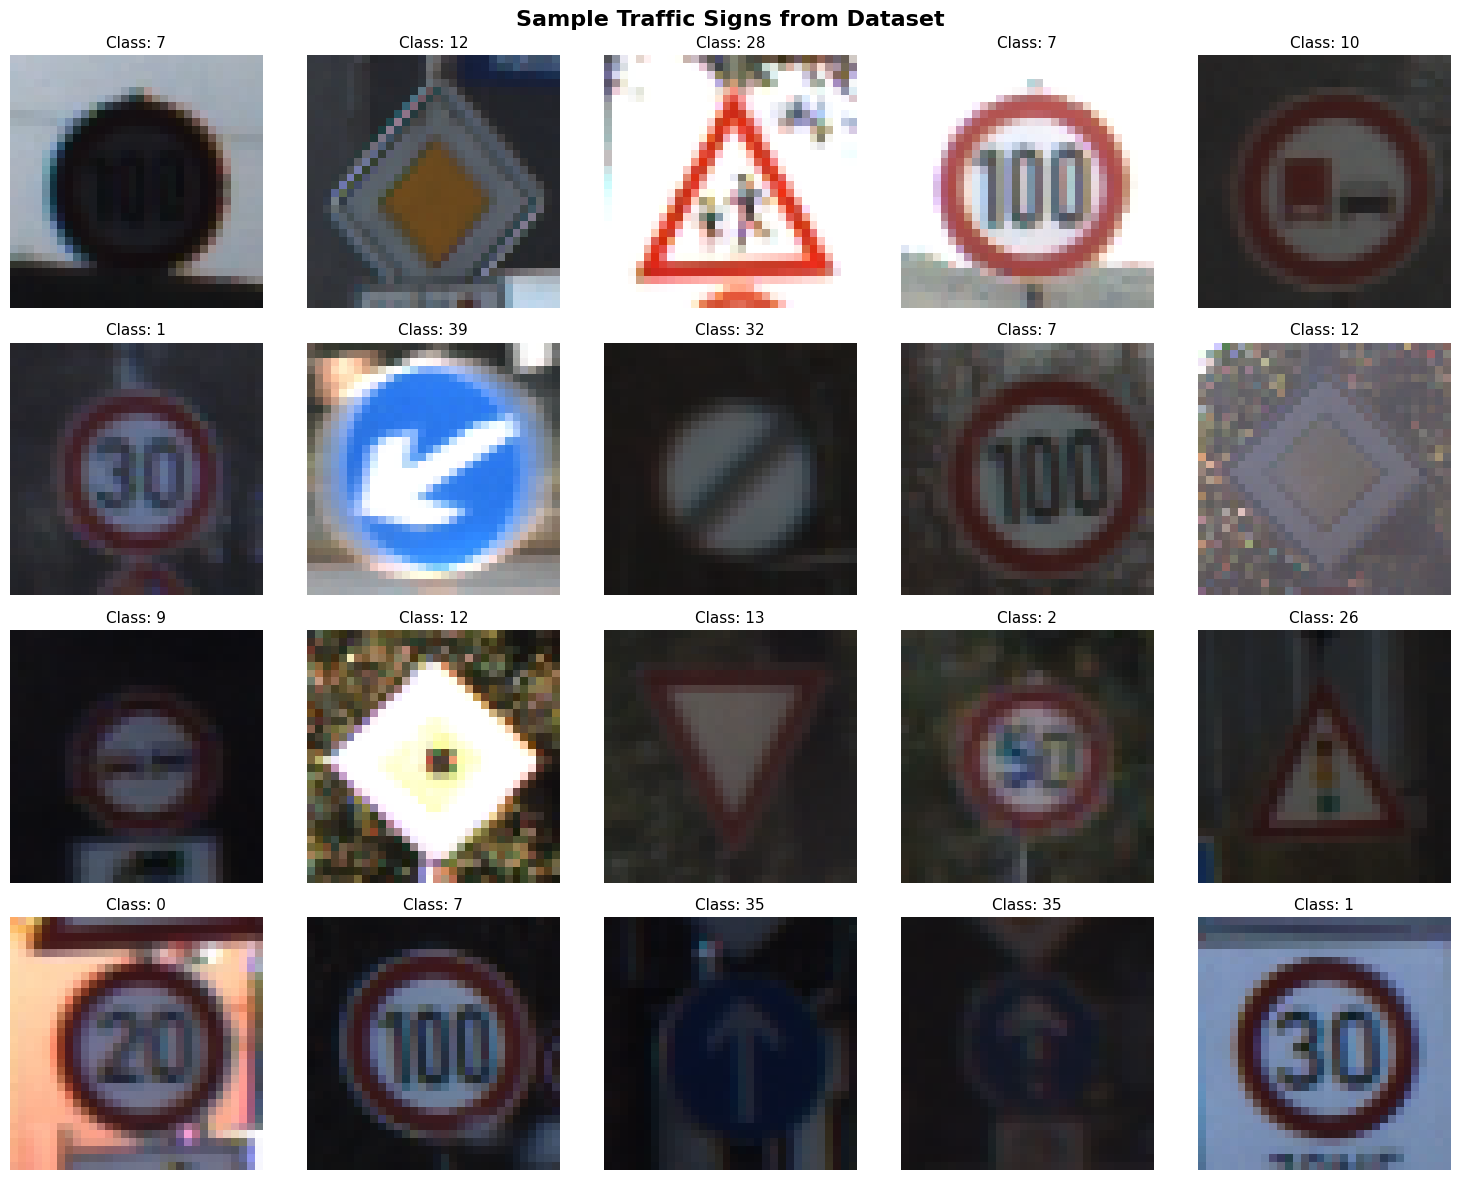


Plotting class distribution...


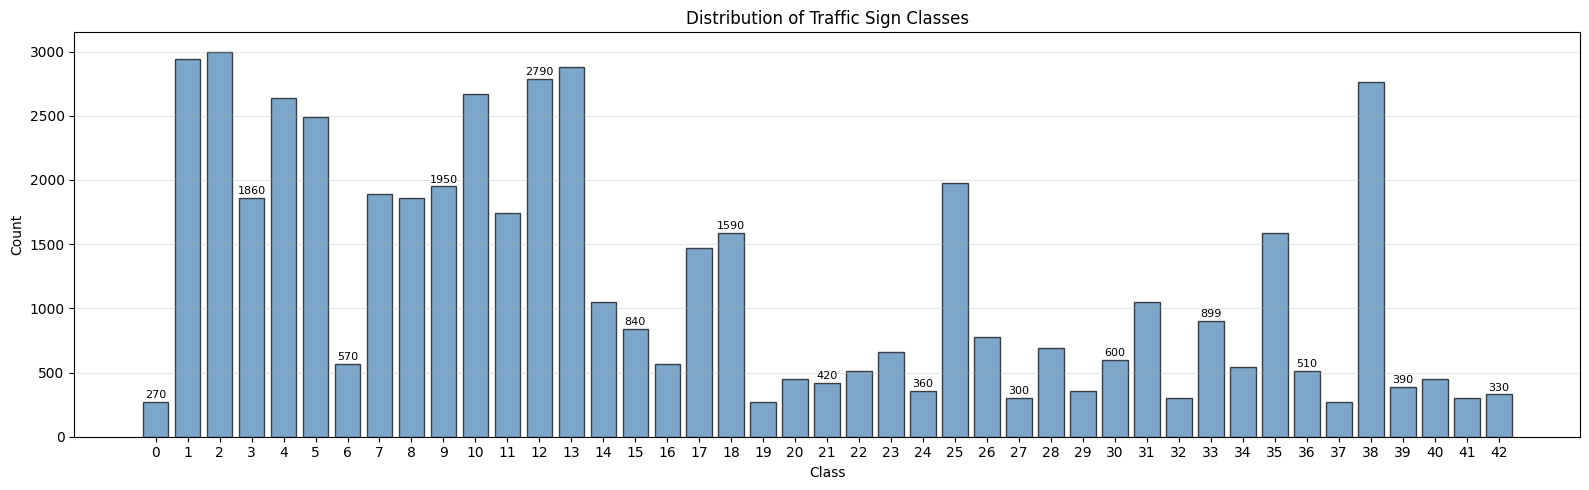


BUILDING MLP MODEL (L2 regularization)

✓ Model built successfully (with L2)


/Applications/SLIIT/Y4/S1/DL/Assignment/TrafficSignRecognition_MLP_model/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Traffic_Sign_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,746,731 (6.66 MB)

 Trainable params: 1,744,939 (6.66 MB)

 Non-trainable params: 1,792 (7.00 KB)


TRAINING MODEL
Epoch 1/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4082 - loss: 2.3805
Epoch 1: val_accuracy improved from None to 0.59105, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5652 - loss: 1.6677 - val_accuracy: 0.5910 - val_loss: 1.5559 - learning_rate: 0.0010
Epoch 2/50
766/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7345 - loss: 1.0046
Epoch 2: val_accuracy improved from 0.59105 to 0.80941, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7517 - loss: 0.9375 - val_accuracy: 0.8094 - val_loss: 0.7524 - learning_rate: 0.0010
Epoch 3/50
765/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7787 - loss: 0.8222
Epoch 3: val_accuracy improved from 0.80941 to 0.86497, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7938 - loss: 0.7723 - val_accuracy: 0.8650 - val_loss: 0.5352 - learning_rate: 0.0010
Epoch 4/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8157 - loss: 0.6988
Epoch 4: val_accuracy did not improve from 0.86497
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8263 - loss: 0.6599 - val_accuracy: 0.8430 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 5/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8386 - loss: 0.6161
Epoch 5: val_accuracy improved from 0.86497 to 0.87770, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8423 - loss: 0.5985 - val_accuracy: 0.8777 - val_loss: 0.4489 - learning_rate: 0.0010
Epoch 6/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8456 - loss: 0.5849
Epoch 6: val_accuracy improved from 0.87770 to 0.89815, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8526 - loss: 0.5644 - val_accuracy: 0.8981 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 7/50
767/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8585 - loss: 0.5479
Epoch 7: val_accuracy did not improve from 0.89815
770/770 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8588 - loss: 0.5474 - val_accuracy: 0.8947 - val_loss: 0.4285 - learning_rate: 0.0010
Epoch 8/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8661 - loss: 0.5283
Epoch 8: val_accuracy improved from 0.89815 to 0.91782, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8689 - loss: 0.5160 - val_accuracy: 0.9178 - val_loss: 0.3828 - learning_rate: 0.0010
Epoch 9/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8698 - loss: 0.5169
Epoch 9: val_accuracy did not improve from 0.91782
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8728 - loss: 0.5078 - val_accuracy: 0.9066 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 10/50
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8746 - loss: 0.5000
Epoch 10: val_accuracy improved from 0.91782 to 0.93248, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8773 - loss: 0.4959 - val_accuracy: 0.9325 - val_loss: 0.3224 - learning_rate: 0.0010
Epoch 11/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8729 - loss: 0.5113
Epoch 11: val_accuracy did not improve from 0.93248
770/770 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8727 - loss: 0.5099 - val_accuracy: 0.8989 - val_loss: 0.4475 - learning_rate: 0.0010
Epoch 12/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8799 - loss: 0.4924
Epoch 12: val_accuracy did not improve from 0.93248
770/770 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8836 - loss: 0.4817 - val_accuracy: 0.9109 - val_loss: 0.4094 - learning_rate: 0.0010
Epoch 13/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8819 - loss: 0.4866
Epoch 13: val_accuracy did not improve from 0.93248
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8844 - loss: 0.4814 - val_accuracy: 0.9198 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 14/5

770/770 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8885 - loss: 0.4713 - val_accuracy: 0.9429 - val_loss: 0.3038 - learning_rate: 0.0010
Epoch 16/50
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8864 - loss: 0.4783
Epoch 16: val_accuracy did not improve from 0.94290
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8890 - loss: 0.4718 - val_accuracy: 0.9217 - val_loss: 0.3875 - learning_rate: 0.0010
Epoch 17/50
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8943 - loss: 0.4598
Epoch 17: val_accuracy did not improve from 0.94290
770/770 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8946 - loss: 0.4541 - val_accuracy: 0.9267 - val_loss: 0.3651 - learning_rate: 0.0010
Epoch 18/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8923 - loss: 0.4646
Epoch 18: val_accuracy did not improve from 0.94290
770/770 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8936 - loss: 0.4595 - val_accuracy: 0.9267 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 19/50


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8949 - loss: 0.4545 - val_accuracy: 0.9448 - val_loss: 0.2991 - learning_rate: 0.0010
Epoch 20/50
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8991 - loss: 0.4462
Epoch 20: val_accuracy did not improve from 0.94483
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8979 - loss: 0.4476 - val_accuracy: 0.9155 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 21/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8998 - loss: 0.4444
Epoch 21: val_accuracy did not improve from 0.94483
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9016 - loss: 0.4374 - val_accuracy: 0.9417 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 22/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9000 - loss: 0.4417
Epoch 22: val_accuracy did not improve from 0.94483
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9005 - loss: 0.4417 - val_accuracy: 0.9228 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 23/50


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9033 - loss: 0.4315 - val_accuracy: 0.9552 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 24/50
765/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9010 - loss: 0.4405
Epoch 24: val_accuracy did not improve from 0.95525
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9033 - loss: 0.4326 - val_accuracy: 0.9429 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 25/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9038 - loss: 0.4358
Epoch 25: val_accuracy did not improve from 0.95525
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9037 - loss: 0.4340 - val_accuracy: 0.9348 - val_loss: 0.3389 - learning_rate: 0.0010
Epoch 26/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9039 - loss: 0.4371
Epoch 26: val_accuracy did not improve from 0.95525
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9037 - loss: 0.4343 - val_accuracy: 0.9190 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 27/50


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9287 - loss: 0.3535 - val_accuracy: 0.9653 - val_loss: 0.2394 - learning_rate: 5.0000e-04
Epoch 30/50
767/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9272 - loss: 0.3525
Epoch 30: val_accuracy did not improve from 0.96528
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9288 - loss: 0.3476 - val_accuracy: 0.9641 - val_loss: 0.2382 - learning_rate: 5.0000e-04
Epoch 31/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9310 - loss: 0.3433
Epoch 31: val_accuracy improved from 0.96528 to 0.97801, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9306 - loss: 0.3399 - val_accuracy: 0.9780 - val_loss: 0.2079 - learning_rate: 5.0000e-04
Epoch 32/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9321 - loss: 0.3330
Epoch 32: val_accuracy did not improve from 0.97801
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9313 - loss: 0.3342 - val_accuracy: 0.9703 - val_loss: 0.2170 - learning_rate: 5.0000e-04
Epoch 33/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9298 - loss: 0.3372
Epoch 33: val_accuracy did not improve from 0.97801
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9305 - loss: 0.3363 - val_accuracy: 0.9749 - val_loss: 0.2114 - learning_rate: 5.0000e-04
Epoch 34/50
766/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9325 - loss: 0.3297
Epoch 34: val_accuracy did not improve from 0.97801
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9317 - loss: 0.3328 - val_accuracy: 0.9749 - val_loss: 0.2115 - learning_rate: 5.0000e

770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9441 - loss: 0.2812 - val_accuracy: 0.9799 - val_loss: 0.1840 - learning_rate: 2.5000e-04
Epoch 40/50
766/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9450 - loss: 0.2778
Epoch 40: val_accuracy did not improve from 0.97994
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9460 - loss: 0.2747 - val_accuracy: 0.9796 - val_loss: 0.1861 - learning_rate: 2.5000e-04
Epoch 41/50
766/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9470 - loss: 0.2718
Epoch 41: val_accuracy did not improve from 0.97994
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9466 - loss: 0.2710 - val_accuracy: 0.9799 - val_loss: 0.1888 - learning_rate: 2.5000e-04
Epoch 42/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9462 - loss: 0.2733
Epoch 42: val_accuracy improved from 0.97994 to 0.98071, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9474 - loss: 0.2691 - val_accuracy: 0.9807 - val_loss: 0.1760 - learning_rate: 2.5000e-04
Epoch 43/50
766/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9484 - loss: 0.2660
Epoch 43: val_accuracy did not improve from 0.98071
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9477 - loss: 0.2665 - val_accuracy: 0.9788 - val_loss: 0.1854 - learning_rate: 2.5000e-04
Epoch 44/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9464 - loss: 0.2694
Epoch 44: val_accuracy improved from 0.98071 to 0.98148, saving model to ../models/best_traffic_sign_mlp.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9484 - loss: 0.2626 - val_accuracy: 0.9815 - val_loss: 0.1682 - learning_rate: 2.5000e-04
Epoch 45/50
767/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9475 - loss: 0.2662
Epoch 45: val_accuracy did not improve from 0.98148
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9480 - loss: 0.2606 - val_accuracy: 0.9769 - val_loss: 0.1797 - learning_rate: 2.5000e-04
Epoch 46/50
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9490 - loss: 0.2615
Epoch 46: val_accuracy did not improve from 0.98148
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9488 - loss: 0.2597 - val_accuracy: 0.9788 - val_loss: 0.1862 - learning_rate: 2.5000e-04
Epoch 47/50
767/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9473 - loss: 0.2622
Epoch 47: val_accuracy did not improve from 0.98148
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9491 - loss: 0.2573 - val_accuracy: 0.9807 - val_loss: 0.1690 - learning_rate: 2.5000e

770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9501 - loss: 0.2524 - val_accuracy: 0.9842 - val_loss: 0.1665 - learning_rate: 2.5000e-04
Epoch 49/50
769/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9493 - loss: 0.2536
Epoch 49: val_accuracy did not improve from 0.98418
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9495 - loss: 0.2520 - val_accuracy: 0.9772 - val_loss: 0.1851 - learning_rate: 2.5000e-04
Epoch 50/50
768/770 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9502 - loss: 0.2485
Epoch 50: val_accuracy did not improve from 0.98418
770/770 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9501 - loss: 0.2472 - val_accuracy: 0.9726 - val_loss: 0.1867 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 48.

Plotting training history...


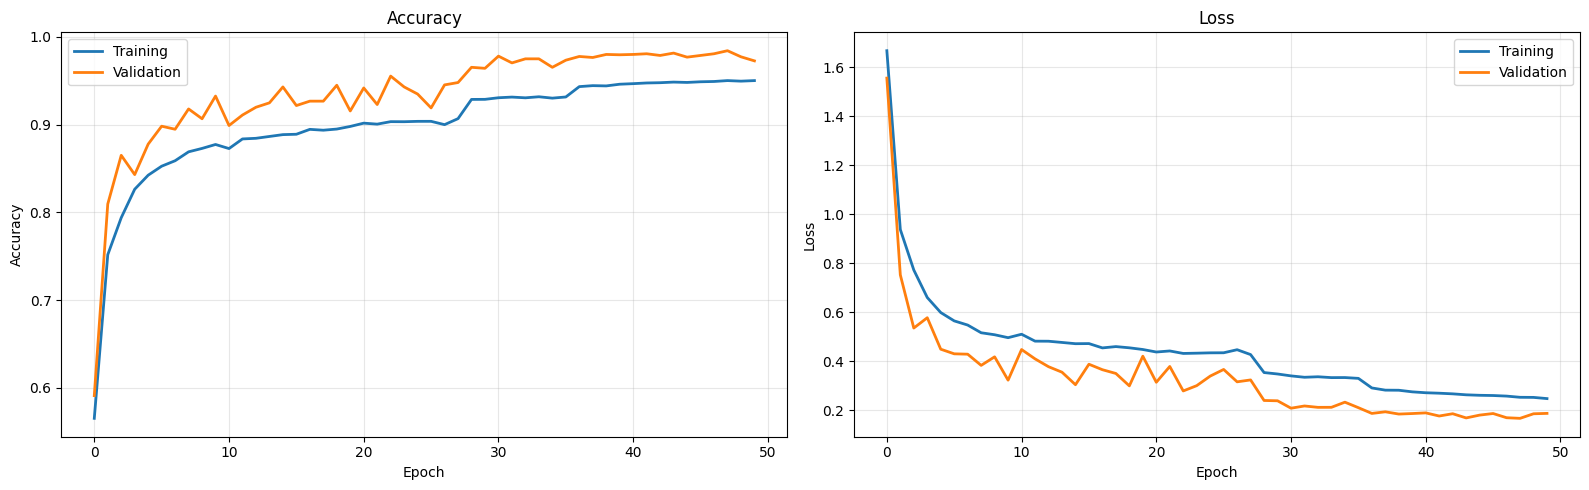


EVALUATING MODEL

  HOLD-OUT ACCURACY: 98.42%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.97      0.98      0.98       147
           2       0.97      0.97      0.97       150
           3       1.00      0.96      0.98        93
           4       0.96      0.98      0.97       132
           5       0.98      0.97      0.97       125
           6       1.00      1.00      1.00        28
           7       0.98      0.98      0.98        95
           8       0.97      0.98      0.97        93
           9       0.99      0.99      0.99        98
          10       0.99      1.00      1.00       134
          11       1.00      0.98      0.99        87
          12       0.99      0.98      0.99       140
          13       0.97      1.00      0.99       144
          14       1.00      1.00      1.00        53
          15       1.00      0.98      0.99        42
         

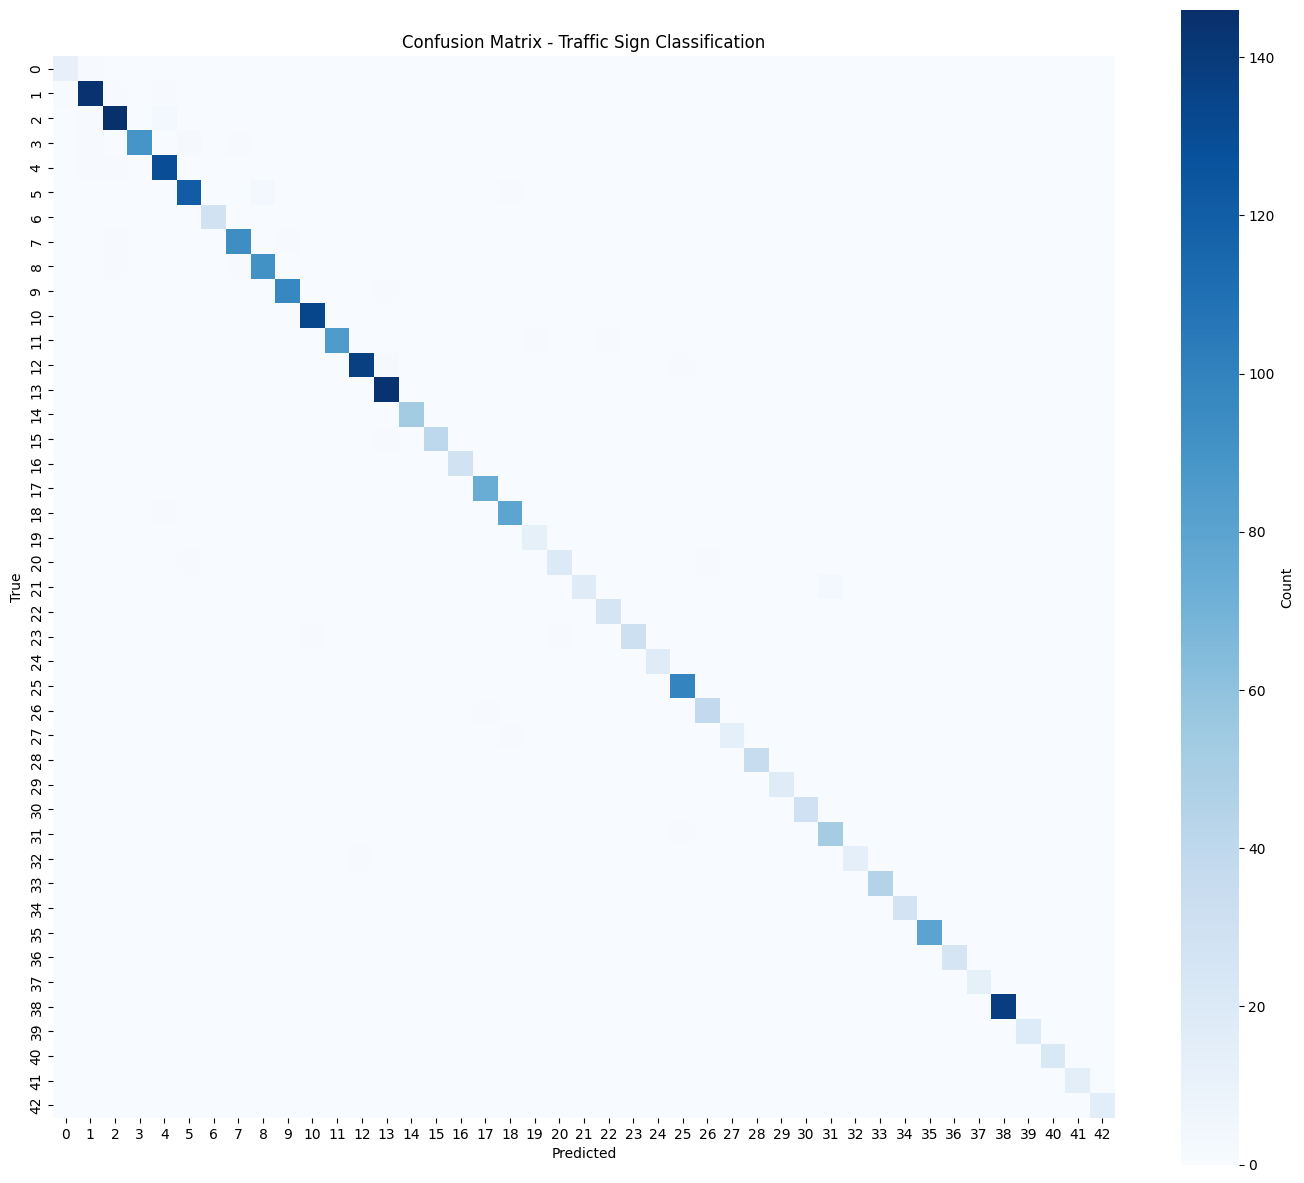


Visualizing sample predictions...


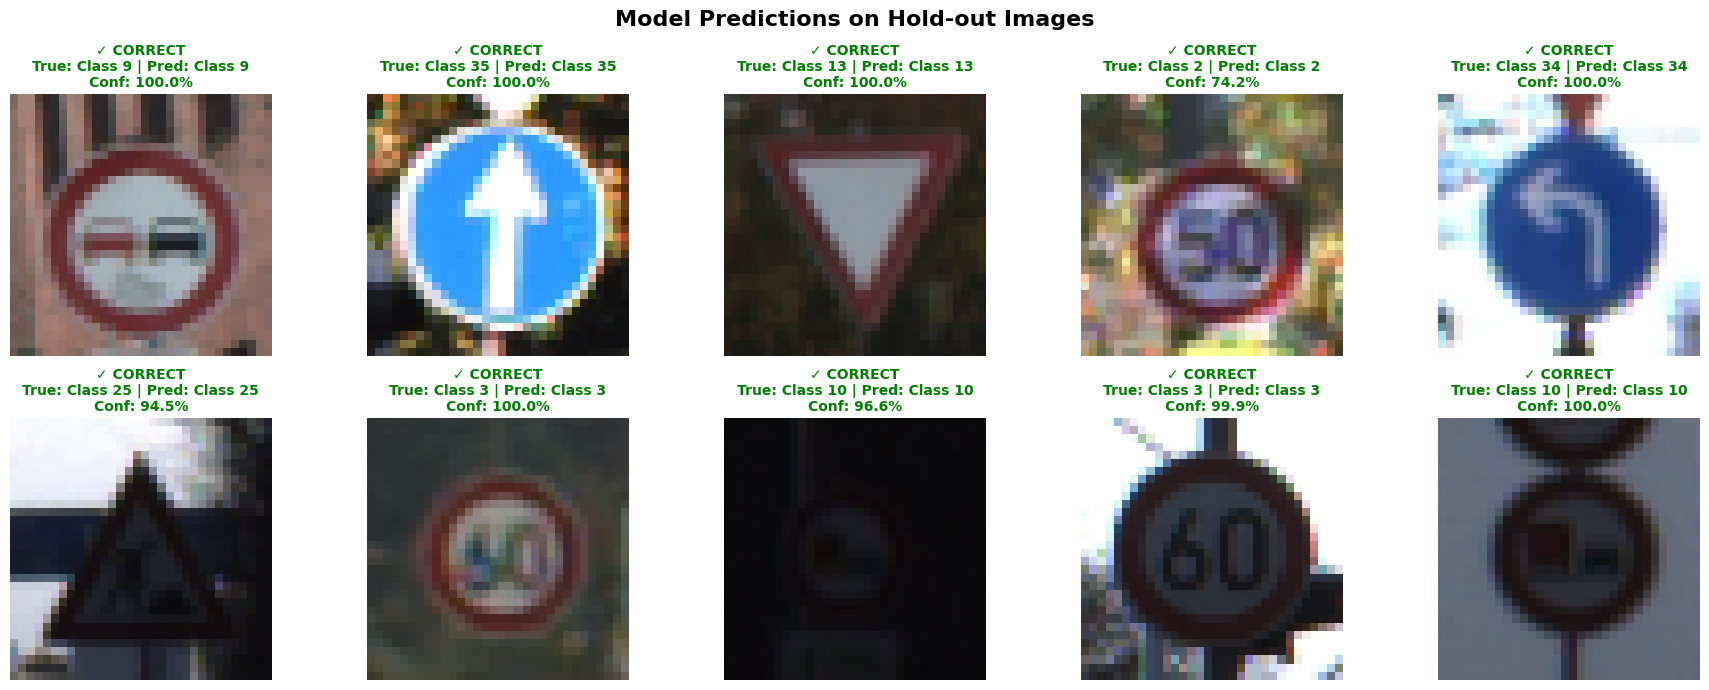


✓ Model saved as '../models/traffic_sign_mlp_final.h5'
✓ Model info saved as '../models/model_info.pkl'

  TRAINING COMPLETE (Train+Test with 5% hold-out)!


In [52]:
model, y_pred, y_true, y_pred_probs, X_val, y_val, class_names = main()

In [53]:
# ============================================================================
# MODEL EVALUATION SUMMARY (hold-out set)
# ============================================================================

accuracy    = accuracy_score(y_true, y_pred)
precision_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_w    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_w        = f1_score(y_true, y_pred, average='weighted',   zero_division=0)
f1_macro    = f1_score(y_true, y_pred, average='macro',      zero_division=0)

test_samples   = len(y_true)
correct        = int(accuracy * test_samples)
incorrect      = test_samples - correct
error_rate     = 1 - accuracy
mean_confidence= float(np.mean(np.max(y_pred_probs, axis=1)))

model_path = MODELS_DIR / 'traffic_sign_mlp_final.h5'

print("\n" + "="*70)
print("MODEL EVALUATION SUMMARY (5% HOLD-OUT)")
print("="*70)
print(f"{'Model:':22s} Multi-Layer Perceptron (MLP)")
print(f"{'Model Path:':22s} {model_path}")
print(f"{'Samples (hold-out):':22s} {test_samples:,}")
print(f"{'Accuracy:':22s} {accuracy:.4f}")
print(f"{'Precision (Weighted):':22s} {precision_w:.4f}")
print(f"{'Recall (Weighted):':22s} {recall_w:.4f}")
print(f"{'Weighted F1 Score:':22s} {f1_w:.4f}")
print(f"{'Macro F1 Score:':22s} {f1_macro:.4f}")
print(f"{'Mean Confidence:':22s} {mean_confidence:.4f}")
print(f"{'Correct:':22s} {correct:,}")
print(f"{'Incorrect:':22s} {incorrect:,}")
print(f"{'Error Rate:':22s} {error_rate:.4f}")
print("="*70 + "\n")

# Save to outputs/
summary_txt = OUTPUTS_DIR / "model_evaluation_summary.txt"
with open(summary_txt, "w") as f:
    f.write(
        "Model Evaluation Summary (5% Hold-out)\n"
        f"Model\tMulti-Layer Perceptron (MLP)\n"
        f"Model Path\t{model_path}\n"
        f"Samples (hold-out)\t{test_samples}\n"
        f"Accuracy\t{accuracy:.4f}\n"
        f"Precision (Weighted)\t{precision_w:.4f}\n"
        f"Recall (Weighted)\t{recall_w:.4f}\n"
        f"Weighted F1 Score\t{f1_w:.4f}\n"
        f"Macro F1 Score\t{f1_macro:.4f}\n"
        f"Mean Confidence\t{mean_confidence:.4f}\n"
        f"Correct\t{correct}\n"
        f"Incorrect\t{incorrect}\n"
        f"Error Rate\t{error_rate:.4f}\n"
    )

import csv
summary_csv = OUTPUTS_DIR / "model_evaluation_summary.csv"
with open(summary_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["Metric", "Value"])
    w.writerow(["Model", "Multi-Layer Perceptron (MLP)"])
    w.writerow(["Model Path", str(model_path)])
    w.writerow(["Samples (hold-out)", test_samples])
    w.writerow(["Accuracy", f"{accuracy:.4f}"])
    w.writerow(["Precision (Weighted)", f"{precision_w:.4f}"])
    w.writerow(["Recall (Weighted)", f"{recall_w:.4f}"])
    w.writerow(["Weighted F1 Score", f"{f1_w:.4f}"])
    w.writerow(["Macro F1 Score", f"{f1_macro:.4f}"])
    w.writerow(["Mean Confidence", f"{mean_confidence:.4f}"])
    w.writerow(["Correct", correct])
    w.writerow(["Incorrect", incorrect])
    w.writerow(["Error Rate", f"{error_rate:.4f}"])

print(f"Saved summary to:\n- {summary_txt}\n- {summary_csv}")


MODEL EVALUATION SUMMARY (5% HOLD-OUT)
Model:                 Multi-Layer Perceptron (MLP)
Model Path:            ../models/traffic_sign_mlp_final.h5
Samples (hold-out):    2,592
Accuracy:              0.9842
Precision (Weighted):  0.9844
Recall (Weighted):     0.9842
Weighted F1 Score:     0.9841
Macro F1 Score:        0.9833
Mean Confidence:       0.9822
Correct:               2,551
Incorrect:             41
Error Rate:            0.0158

Saved summary to:
- ../outputs/model_evaluation_summary.txt
- ../outputs/model_evaluation_summary.csv


In [54]:
#evaluation metics ==========
from pathlib import Path
import os, cv2, numpy as np, pandas as pd
from tensorflow.keras.utils import to_categorical

def preprocess_data(images, labels, img_size=32):
    resized_images = np.array([cv2.resize(img, (img_size, img_size)) for img in images])
    normalized_images = resized_images.astype('float32') / 255.0
    X = normalized_images.reshape(len(normalized_images), -1)
    n_classes = len(np.unique(labels))
    y = to_categorical(labels, n_classes)
    return X, y, n_classes, normalized_images

def load_gtsrb_dataset(data_dir):
    """Load TRAIN split from data_dir/Train/<class>/*"""
    data_dir = Path(data_dir)
    train_path = data_dir / "Train"
    if not train_path.exists():
        raise FileNotFoundError(f"Missing: {train_path}")
    images, labels = [], []
    classes = sorted([d for d in os.listdir(train_path) if (train_path / d).is_dir()])
    for class_num in classes:
        class_path = train_path / class_num
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png','.jpg','.jpeg','.ppm')):
                img = cv2.imread(str(class_path / f))
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img); labels.append(int(class_num))
    return images, np.array(labels)

def _find_test_labels_csv(test_dir: Path, data_dir: Path):
    candidates = list(test_dir.glob("*.csv")) + list(data_dir.glob("*.csv"))
    for csv_path in candidates:
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            continue
        cols = {c.lower(): c for c in df.columns}
        if "classid" in cols and (("path" in cols) or ("filename" in cols) or any("file" in c.lower() for c in df.columns)):
            return csv_path
    return None

def load_gtsrb_official_test(data_dir):
    """Load OFFICIAL Test/ using a labels CSV (auto-detect common formats)."""
    data_dir = Path(data_dir)
    test_dir = data_dir / "Test"
    if not test_dir.exists():
        raise FileNotFoundError(f"Missing: {test_dir}")
    csv_path = _find_test_labels_csv(test_dir, data_dir)
    if csv_path is None:
        raise FileNotFoundError("Could not locate a labels CSV for Test/ (e.g., Test.csv or GT-final_test.csv).")
    df = pd.read_csv(csv_path)
    cols = {c.lower(): c for c in df.columns}
    # pick filename/path column
    if "path" in cols: file_col = cols["path"]
    elif "filename" in cols: file_col = cols["filename"]
    else:
        file_col = next((c for c in df.columns if "file" in c.lower()), None)
        if file_col is None:
            raise ValueError(f"Can't infer filename column in {csv_path.name}")
    class_col = cols.get("classid", None)
    if class_col is None: raise ValueError(f"No 'ClassId' column in {csv_path.name}")

    images_test, labels_test = [], []
    for _, row in df.iterrows():
        rel = str(row[file_col])
        img_path = (data_dir / rel) if rel.startswith("Test") else (test_dir / rel)
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images_test.append(img); labels_test.append(int(row[class_col]))
    if not images_test:
        raise RuntimeError("Loaded 0 test images. Check CSV filenames vs files in Test/.")
    return images_test, np.array(labels_test)

In [55]:
# ==== PREDICTION HELPERS (self-contained) ====
from pathlib import Path
import numpy as np, pandas as pd, cv2, matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---- Paths (adjust if needed) ----
BASE_DIR    = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
MODEL_PATH  = BASE_DIR / 'models' / 'traffic_sign_mlp_final.h5'   # adjust if different
META_DIR    = BASE_DIR / 'data' / 'Meta'                          # optional
OUTPUTS_DIR = BASE_DIR / 'outputs'
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load model ----
model = load_model(MODEL_PATH)
print("Loaded model:", MODEL_PATH)

# ---- Class names (optional, from Meta/signnames.csv if present) ----
def load_class_names(meta_dir: Path):
    if (meta_dir).exists():
        for csv in list(meta_dir.glob("*.csv")) + list(meta_dir.parent.glob("*.csv")):
            try:
                df = pd.read_csv(csv)
                cols = {c.lower(): c for c in df.columns}
                if 'classid' in cols and any(k in cols for k in ['signname','classname','name']):
                    name_col = cols.get('signname') or cols.get('classname') or cols.get('name')
                    return {int(r[cols['classid']]): str(r[name_col]) for _, r in df.iterrows()}
            except Exception:
                pass
    return {}

CLASS_NAMES = load_class_names(META_DIR)
if CLASS_NAMES:
    print(f"Loaded {len(CLASS_NAMES)} class names.")
else:
    print("No Meta file found; will show numeric class IDs.")

# ---- Preprocessing for MLP (robust) ----
def _letterbox_rgb(img_rgb, target=32):
    h, w = img_rgb.shape[:2]
    if h == w:
        sq = img_rgb
    elif h > w:
        pad = (h - w) // 2
        sq = cv2.copyMakeBorder(img_rgb, 0, 0, pad, h - w - pad, cv2.BORDER_CONSTANT, value=(0,0,0))
    else:
        pad = (w - h) // 2
        sq = cv2.copyMakeBorder(img_rgb, pad, w - h - pad, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    return cv2.resize(sq, (target, target), interpolation=cv2.INTER_AREA)

def _enhance_contrast(img_rgb):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L,A,B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    L = clahe.apply(L)
    return cv2.cvtColor(cv2.merge([L,A,B]), cv2.COLOR_LAB2RGB)

def preprocess_for_mlp(img_bgr, img_size=32):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = _enhance_contrast(img_rgb)
    img_rgb = cv2.medianBlur(img_rgb, 3)
    img_rgb = _letterbox_rgb(img_rgb, target=img_size)
    arr = img_rgb.astype('float32')/255.0
    x = arr.reshape(1, -1)   # flattened for MLP
    return img_rgb, x

# ---- Single-image predictor (with TTA + unknown threshold) ----
def predict_image(image_path, img_size=32, tta=True, unknown_threshold=0.55, show=True):
    """
    Returns dict with: pred_index | pred_label | confidence | unknown | top3
    """
    p = Path(image_path)
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {p}")

    if not tta:
        disp, x = preprocess_for_mlp(img_bgr, img_size)
        probs = model.predict(x, verbose=0)[0]
    else:
        angles = [-10, 0, 10]
        acc = []
        h, w = img_bgr.shape[:2]
        for a in angles:
            M = cv2.getRotationMatrix2D((w/2, h/2), a, 1.0)
            rot = cv2.warpAffine(img_bgr, M, (w, h), borderValue=(0,0,0))
            disp, x = preprocess_for_mlp(rot, img_size)
            acc.append(model.predict(x, verbose=0)[0])
        probs = np.mean(acc, axis=0)

    top_idx = int(np.argmax(probs))
    conf = float(np.max(probs))
    unknown = conf < unknown_threshold

    def cname(i): return CLASS_NAMES.get(i, f"Class {i}")
    label = "Unknown" if unknown else cname(top_idx)
    top3_idx = np.argsort(probs)[-3:][::-1]
    top3 = [(cname(i), float(probs[i])) for i in top3_idx]

    if show:
        plt.figure(figsize=(6,5))
        plt.imshow(disp)
        title = f"{label}  ({conf*100:.1f}%)"
        plt.title(title, color=('red' if unknown else 'green'), fontsize=12, fontweight='bold')
        plt.axis('off'); plt.tight_layout(); plt.show()

        print("Top-3:")
        for i,(name,pc) in enumerate(top3,1):
            print(f"  {i}. {name}: {pc*100:.2f}%")

    return {"pred_index": (None if unknown else top_idx),
            "pred_label": label,
            "confidence": conf,
            "unknown": unknown,
            "top3": top3}

# ---- Batch folder predictor (saves CSV) ----
def predict_folder(folder_path, img_size=32, tta=True, unknown_threshold=0.55, patterns=('.png','.jpg','.jpeg','.ppm')):
    folder = Path(folder_path)
    rows = []
    for f in sorted(folder.rglob('*')):
        if f.suffix.lower() in patterns:
            try:
                res = predict_image(f, img_size=img_size, tta=tta, unknown_threshold=unknown_threshold, show=False)
                rows.append({
                    "image": str(f),
                    "pred_label": res["pred_label"],
                    "pred_index": res["pred_index"] if res["pred_index"] is not None else -1,
                    "confidence": res["confidence"],
                    "unknown": res["unknown"],
                    "top1": res["top3"][0][0], "top1_prob": res["top3"][0][1],
                    "top2": res["top3"][1][0], "top2_prob": res["top3"][1][1],
                    "top3": res["top3"][2][0], "top3_prob": res["top3"][2][1],
                })
            except Exception as e:
                rows.append({"image": str(f), "error": str(e)})
    df = pd.DataFrame(rows)
    out_csv = OUTPUTS_DIR / "predictions_batch.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved batch predictions to: {out_csv}")
    return df

Loaded model: /Applications/SLIIT/Y4/S1/DL/Assignment/TrafficSignRecognition_MLP_model/models/traffic_sign_mlp_final.h5
No Meta file found; will show numeric class IDs.


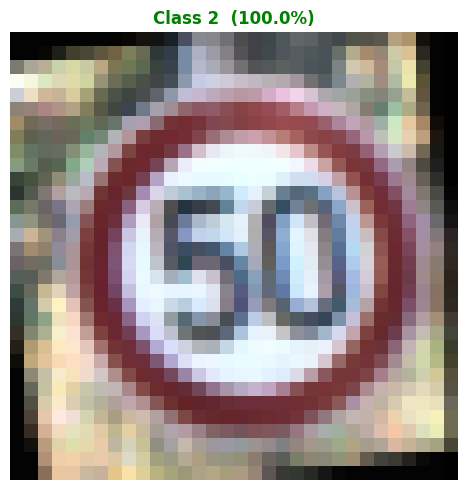

Top-3:
  1. Class 2: 100.00%
  2. Class 1: 0.00%
  3. Class 24: 0.00%
Saved batch predictions to: /Applications/SLIIT/Y4/S1/DL/Assignment/TrafficSignRecognition_MLP_model/outputs/predictions_batch.csv


,image,pred_label,pred_index,confidence,unknown,top1,top1_prob,top2,top2_prob,top3,top3_prob
0,/Applications/SLIIT/Y4/S1/DL/Assignment/Traffi...,Class 16,16,0.999269,False,Class 16,0.999269,Class 40,0.000627,Class 10,0.000072
1,/Applications/SLIIT/Y4/S1/DL/Assignment/Traffi...,Class 1,1,0.993120,False,Class 1,0.993120,Class 7,0.004347,Class 5,0.000942
2,/Applications/SLIIT/Y4/S1/DL/Assignment/Traffi...,Class 12,12,0.999798,False,Class 12,0.999798,Class 4,0.000041,Class 32,0.000029
3,/Applications/SLIIT/Y4/S1/DL/Assignment/Traffi...,Class 20,20,0.982240,False,Class 20,0.982240,Class 3,0.008293,Class 28,0.004408
4,/Applications/SLIIT/Y4/S1/DL/Assignment/Traffi...,Class 2,2,0.999953,False,Class 2,0.999953,Class 1,0.000039,Class 24,0.000005


In [60]:
# --- Single image ---

_ = predict_image(image_path=DATA_DIR / "predict" / "00034.png",
                  img_size=32, tta=True, unknown_threshold=0.55, show=True)

# --- Batch over a folder (saves outputs/predictions_batch.csv) ---
# Update the folder path that contains images:
df_preds = predict_folder(folder_path=DATA_DIR / "predict",
                          img_size=32, tta=True, unknown_threshold=0.55)
df_preds.head()